In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import array
from numpy import newaxis
import math
from scipy import stats
from subprocess import check_output
# from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM
# from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time #helper libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model


In [39]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [40]:
#load your data to train or predict on 
raw_data = pd.read_csv(f"https://s3.amazonaws.com/globefutures/data/CME_CL1.csv", usecols=[7])


In [41]:
df = raw_data

In [42]:
data_frame = df.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame = data_frame.sort_index(ascending=True, axis=0)
df = data_frame.reindex(index=data_frame.index[::-1])
df.tail()

,Settle
4,65.21
3,63.30
2,63.50
1,63.91
0,63.60


In [43]:
df_z = np.abs(stats.zscore(df))
print(df_z)

[[0.47236259]
 [0.4762087 ]
 [0.470964  ]
 ...
 [0.7199309 ]
 [0.7342664 ]
 [0.72342736]]


In [44]:
threshhold = 5
print(np.where(df_z>threshhold))
df_o = df[(df_z < threshhold).all(axis=1)]


(array([], dtype=int64), array([], dtype=int64))


In [45]:
print(f"Raw Data: {df.shape}")
print(f"Data with Z-Scores > {threshhold} removed: {df_o.shape}")


Raw Data: (9068, 1)
Data with Z-Scores > 5 removed: (9068, 1)


In [46]:
dataset = df_o
dataset = dataset.values
dataset = dataset.astype('float32')
dataset

array([[29.4 ],
       [29.29],
       [29.44],
       ...,
       [63.5 ],
       [63.91],
       [63.6 ]], dtype=float32)

In [47]:
#scale the data, makes the model happy
np.random.seed(7)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.14072812],
       [0.13991253],
       [0.14102471],
       ...,
       [0.39356422],
       [0.39660418],
       [0.39430565]], dtype=float32)

In [48]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

6075 2993


In [52]:
look_back = 15 # sets how many steps out from the current step model is looking, 3 is two days in our timeseries. The current day and two days out.
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [53]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX

array([[[0.14072812],
        [0.13991253],
        [0.14102471],
        ...,
        [0.15073776],
        [0.15073776],
        [0.15036704]],

       [[0.13991253],
        [0.14102471],
        [0.14302662],
        ...,
        [0.15073776],
        [0.15036704],
        [0.15021874]],

       [[0.14102471],
        [0.14302662],
        [0.14443539],
        ...,
        [0.15036704],
        [0.15021874],
        [0.15073776]],

       ...,

       [[0.4103952 ],
        [0.39860606],
        [0.40616888],
        ...,
        [0.40290654],
        [0.4118781 ],
        [0.4072811 ]],

       [[0.39860606],
        [0.40616888],
        [0.44961816],
        ...,
        [0.4118781 ],
        [0.4072811 ],
        [0.41402835]],

       [[0.40616888],
        [0.44961816],
        [0.3909691 ],
        ...,
        [0.4072811 ],
        [0.41402835],
        [0.4243346 ]]], dtype=float32)

In [54]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(5, input_shape=(look_back, 1)))
model.add(Dense(3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)


Epoch 1/5
 - 25s - loss: 9.9426e-05
Epoch 2/5
 - 25s - loss: 6.6900e-05
Epoch 3/5
 - 26s - loss: 5.4162e-05
Epoch 4/5
 - 26s - loss: 4.8341e-05
Epoch 5/5
 - 25s - loss: 4.7505e-05


In [298]:
model.save('filename.h5') #change file name! lstm_modelCLstep15, lstm_modelCL

In [26]:
model = load_model('lstm_modelCL.h5') #load a model 

In [78]:
# make predictions
trainPredict = model.predict(trainX, verbose=2)
testPredict = model.predict(testX, verbose=2)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

ValueError: Found array with dim 3. Estimator expected <= 2.

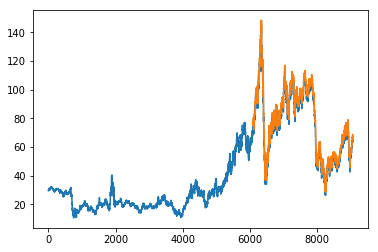

In [79]:
plt.plot(scaler.inverse_transform(dataset[:len(testPredictPlot)]))
plt.plot(testPredictPlot)



In [77]:
print(testPredict)


[[75.09405 ]
 [75.48663 ]
 [75.397285]
 ...
 [68.025345]
 [66.417786]
 [66.16314 ]]


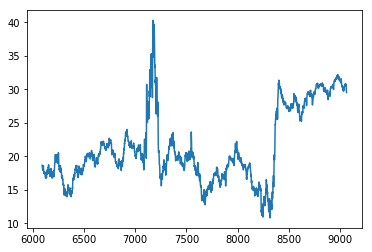

In [319]:
plt.plot(testPredictPlot)


In [438]:
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


Crude Oil Contract - Univariate

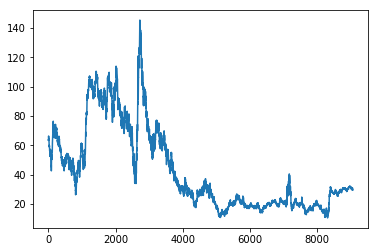